# Supervised Learning - Classification Problem

## Students' dropout and academic success

### (Droupout, Enrolled, Graduate)

Faculdade: FEUP - Faculdade de Engenharia da Universidade do Porto

Curso: L.EIC - Licenciatura em Engenharia Informática e Computação 

Unidade Curricular: Inteliência Artificial

Ano Curricular: 2021/22

Grupo: 21_1D

Elementos:
- Henrique Ribeiro Nunes, up201906852@up.pt
- Margarida Assis Ferreira, up201905046@up.pt
- Patrícia do Carmo Nunes Oliveira, up201905427@up.pt

### Especificação

O foco principal deste problema é analisar a informação conhecida sobre a matrícula do aluno (percurso acadêmico, demografia e fatores socioeconômicos) e o desempenho acadêmico dos alunos no final do primeiro e segundo semestres. Com o objetivo de usar estes dados para construir modelos de classificação para **prever a desistência e o sucesso acadêmico dos alunos**.

Este problema é um ***single label multiclass classification problem*** com 37 atributos:
- 36 métricas distintas para descrever as informações do aluno.
- 1 resultado com 3 resultados possíveis (*Droupout*, *Enrolled*, *Graduate*).

Existe um **forte desbalanceamento** em relação a um dos resultados possíveis.


### Tools & Resources

// TODO AQUI 

### Data Analysis

A análise dos dados é um passo importante nos problemas de classificação. 

Nesta secção são analisados os atributos que classificam os dados e o tipo e intervalo de valores de cada um dos atributos, bem como o tamanho do conjunto de dados, a presença de valores nulos ou amostras duplicadas. Igualmente é explorado a distribuição das classes e de valores por atributos.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [14]:
# Load data
data = pd.read_csv("data/data.csv")

In [15]:
# Print head values and summary statistics
print(data.head())
print()
print(data.describe())
print()

   Marital status  Application mode  Application order  Course  \
0               1                17                  5     171   
1               1                15                  1    9254   
2               1                 1                  5    9070   
3               1                17                  2    9773   
4               2                39                  1    8014   

   Daytime/evening attendance\t  Previous qualification  \
0                             1                       1   
1                             1                       1   
2                             1                       1   
3                             1                       1   
4                             0                       1   

   Previous qualification (grade)  Nacionality  Mother's qualification  \
0                           122.0            1                      19   
1                           160.0            1                       1   
2                         

In [16]:
# Get all 36 metrics used and 3 possible results
metrics = list(data.columns)
metrics.remove("class")
print("Number of Metrics: {}".format(len(metrics)))
print("Metrics: {}".format(metrics))

targets = list(data["class"].unique())
print("\nNumber of Results: {}".format(len(targets)))
print("Result/Prediction: {}".format(targets))

Number of Metrics: 36
Metrics: ['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance\t', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate

In [17]:
# Check atribute types and values interval
for name, dtype in data.dtypes.iteritems():
    print("{} | {} | [{} , {}] ".format(name, dtype, data[name].min(), data[name].max()))

Marital status | int64 | [1 , 6] 
Application mode | int64 | [1 , 57] 
Application order | int64 | [0 , 9] 
Course | int64 | [33 , 9991] 
Daytime/evening attendance	 | int64 | [0 , 1] 
Previous qualification | int64 | [1 , 43] 
Previous qualification (grade) | float64 | [95.0 , 190.0] 
Nacionality | int64 | [1 , 109] 
Mother's qualification | int64 | [1 , 44] 
Father's qualification | int64 | [1 , 44] 
Mother's occupation | int64 | [0 , 194] 
Father's occupation | int64 | [0 , 195] 
Admission grade | float64 | [95.0 , 190.0] 
Displaced | int64 | [0 , 1] 
Educational special needs | int64 | [0 , 1] 
Debtor | int64 | [0 , 1] 
Tuition fees up to date | int64 | [0 , 1] 
Gender | int64 | [0 , 1] 
Scholarship holder | int64 | [0 , 1] 
Age at enrollment | int64 | [17 , 70] 
International | int64 | [0 , 1] 
Curricular units 1st sem (credited) | int64 | [0 , 20] 
Curricular units 1st sem (enrolled) | int64 | [0 , 26] 
Curricular units 1st sem (evaluations) | int64 | [0 , 45] 
Curricular units 1

In [18]:
# Data size
print("Data Size: {}".format(len(data)))

Data Size: 4424


In [19]:
# Check if there are columns with N/A values
print("N/A values found: {}".format(data.isnull().values.any()))

N/A values found: False


In [20]:
# Check if there are duplicated Data
bool_series = data.duplicated()
print(bool_series)

old_size = len(data)

# Removing all duplicated data if exists
data = data[~bool_series] 

new_size = len(data)

# check if there were actualy duplicated data
print()
if (new_size == old_size):
    print("No data was removed: there were no duplicated data")
else:
    print("Was found and removed {} duplicated data".format(old_size-new_size))

0       False
1       False
2       False
3       False
4       False
        ...  
4419    False
4420    False
4421    False
4422    False
4423    False
Length: 4424, dtype: bool

No data was removed: there were no duplicated data


In [21]:
# Resultant data without duplicated entries
data

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,class
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


Number of 'Dropout' occurences: 1421
Number of 'Graduate' occurences: 2209
Number of 'Enrolled' occurences: 794

      class  count
0  Graduate   2209
1   Dropout   1421
2  Enrolled    794


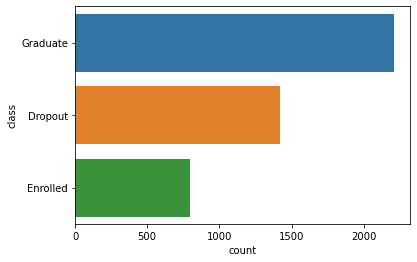

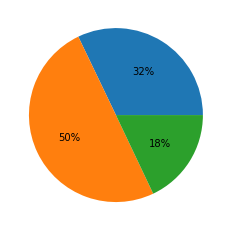

In [22]:
# Class Distribution
# Check data balance
n_dropouts = data['class'].value_counts().Dropout
n_graduate = data['class'].value_counts().Graduate
n_enrroled = data['class'].value_counts().Enrolled
print("Number of 'Dropout' occurences: {}".format(n_dropouts))
print("Number of 'Graduate' occurences: {}".format(n_graduate))
print("Number of 'Enrolled' occurences: {}".format(n_enrroled))
print()

# Corresponding plot 
count_result = pd.DataFrame(data["class"]).value_counts().rename_axis("class").reset_index(name="count")
print(count_result)

# Bar plot
plot_count_res = sb.barplot(data=count_result, x="count", y="class")
plt.show()

# Pie plot with percentages
plt.pie([n_dropouts, n_graduate, n_enrroled], autopct = '%0.00f%%')
plt.show()

// TODO AQUI
(Continuar aqui a fazer graficos por variaveis e sua relação com o resultado: dropout/enrroled/graduate) -> distribuição dos valores dos atributos

**Propriedades do Problema:** (a partir da análise dos dados de entrada)

- Nominal and Discrete attributes (including some binary ones)
- Dimensionality = 37 attibutos
- Size = 4424
- Type = Data Matrix
- No missing or duplicate Data
- No meaningful outliers
- Imbalance data

### Pré-processamento dos dados

Tendo em conta as conclusões obtidas pela a análise dos dados originais mostrada anteriormente, podemos apercebermo-nos que é necessário realizar um pré-processamento dos dados, com o objetivo de resolver o maior problema adjacente a estes: a falta de balanceamento entre as diferentes classes de alvo. 

Para tal podemos usar entre outras estratégias uma das seguintes:
- **oversampling** : «Aumentar o número de amostras/entradas da menor classe até coincidir com o tamanho da maior classe»
- **undersampling** : «Diminuir o número de amostras/entradas da maior classe até coincidir com o tamanho da menor classe»

Em qualquer uma das abordagens acima, a escolha das amostras escolhidas para serem retidas ou replicadas com pequenas modificações é aleatória.

#### Undersampling

Uma das técnicas para lidar com o desbalanceamento de classes em machine lerning é chamado de undersampling. Esta técnica de balanceamento consiste em remover algumas observações das classes majoritárias, até que as classes majoritárias e minoritária sejam equilibradas. O undersampling pode ser uma boa escolha quando temos dados desequilibrados, mas uma desvantagem é que removemos informações que podem ser valiosas.

Para remover as observações das classes majoritárias, usamos a função sample(sequence, k), uma função do módulo random de Python, que retorna uma lista de comprimento k de itens escolhidos aleatoriamente de sequence.

Classes count:
Graduate    2209
Dropout     1421
Enrolled     794
Name: class, dtype: int64


<AxesSubplot:title={'center':'count (target)'}>

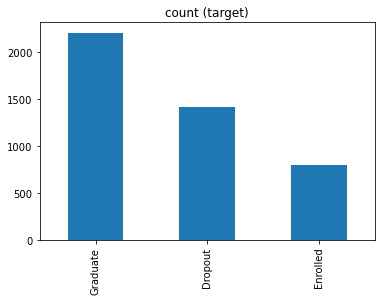

In [23]:
# Imbalance Original Data
print("Classes count:")
print(data['class'].value_counts())

data['class'].value_counts().plot(kind='bar', title='count (target)')

In [25]:
class_graduate = data[data['class'] == "Graduate"]
class_dropout = data[data['class'] == "Dropout"]
class_enrolled = data[data['class'] == "Enrolled"]

class_dropout_under = class_dropout.sample(n_enrroled, replace=True)
class_graduate_under = class_graduate.sample(n_enrroled, replace=True)

Agora temos os nossos dados balanceados, como é possível observer no gráfico criado pelo código abaixo.

Classes count after under-sampeling:
Dropout     794
Graduate    794
Enrolled    794
Name: class, dtype: int64


<AxesSubplot:title={'center':'count (target)'}>

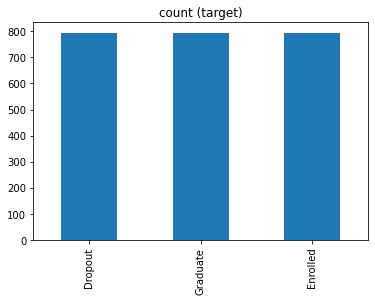

In [26]:
test_under = pd.concat([class_dropout_under, class_graduate_under, class_enrolled], axis=0)

# plot the count after under-sampeling
print("Classes count after under-sampeling:")
print(test_under['class'].value_counts())

test_under['class'].value_counts().plot(kind='bar', title='count (target)')

#### Oversampling

// TODO AQUI -> improve description
Segue o seguinte esquema: [incluir imagem significativa]

As entradas da classe menor sáo replicadas até totalizarem o número de amostras da classe maior.

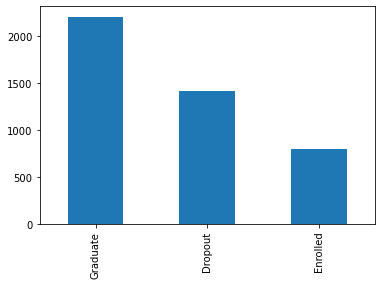

In [27]:
# Imbalance Original Data
unbalanced_count = data['class'].value_counts()
unbalanced_count.plot.bar()
plt.show()

In [28]:
# Separate count and samples by the diferent classes
graduate_count, droupout_count, enrolled_count = data['class'].value_counts()

print("GRADUATE: {} | DROUPOUT: {} | ENROLLED: {}".format(graduate_count, droupout_count, enrolled_count))

graduate_samples = data[data['class'] == "Graduate"]
droupout_samples = data[data['class'] == "Dropout"]
enrolled_samples = data[data['class'] == "Enrolled"]

GRADUATE: 2209 | DROUPOUT: 1421 | ENROLLED: 794


##### Random Over-Sampling

«Oversampling can be defined as adding more copies to the minority class.»

**Disvantagens:** pod causar *overfitting* e pobre generalização do conjunto de dados para teste.

Total dintinct classes: 
Graduate    2209
Dropout     2209
Enrolled    2209
Name: class, dtype: int64


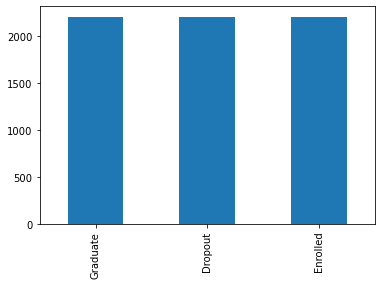

In [29]:
# number of the smallest to the larger ones
droupout_samples_over = droupout_samples.sample(graduate_count, replace=True)
enrolled_samples_over = enrolled_samples.sample(graduate_count, replace=True)

test_samples_over = pd.concat([graduate_samples, droupout_samples_over, enrolled_samples_over], axis=0)

print("Total dintinct classes: \n{}".format(test_samples_over['class'].value_counts()))

rnd_oversampling_count = test_samples_over['class'].value_counts()
rnd_oversampling_count.plot.bar()
plt.show()

##### Synthetic Minority Oversampling Technique (SMOTE)

// TODO AQUI - NOT WORKING

In [ ]:
import imblearn

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
# TODO find want is supposted to be x and y 
x_ros, y_ros = ros.fit_resample(x, y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_ros))


from imblearn.over_sampling import SMOTE

smote = SMOTE()
# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(x, y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_ros))

É importante referir que nenhuma das soluções acima é uma solução perfeita, pois a aplicação de undersampling pode inplicar a perda de infromação, da mesma forma que a aplicação de oversampling (sem qualquer modificação das amostras escolhidas aleatóriamente para serem replicadas) pode levar a um posterior overfitting dos modelos gerados a estes novos dados.


##### Combine under and over sampling

Tendo isto em conta a seguinte tentativa tenta encontrar um meio termos entre as soluções anteriores, fazendo as classes em questão convergir para um valor mediano e não para um máximo nem minímo, tentando combater as consequencias sentidas nos dados ao aplicar isoladamente cada uma das estratégias, obtando por alcaçar um meio termo.

Total dintinct classes: 
Graduate    1421
Dropout     1421
Enrolled    1421
Name: class, dtype: int64


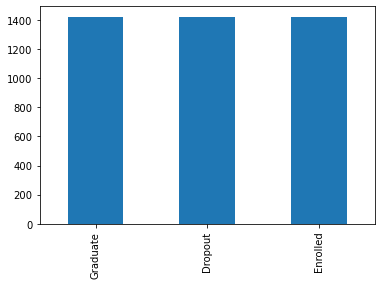

In [30]:
# make the counts meet at the middle point
# in this case the middle point is consider to be the dropout class
graduate_samples_middle = graduate_samples.sample(droupout_count, replace=True)
enrolled_samples_middle = enrolled_samples.sample(droupout_count, replace=True)

test_samples_middle = pd.concat([graduate_samples_middle, droupout_samples, enrolled_samples_middle], axis=0)

print("Total dintinct classes: \n{}".format(test_samples_middle['class'].value_counts()))

middle_sampling_count = test_samples_middle['class'].value_counts()
middle_sampling_count.plot.bar()
plt.show()

### Learning Algorithms

#### Identification of the Target Concept

// TODO AQUI

In [31]:
labels = list(data.columns[:-1]) # Last element is the target column
values = list(data[labels].values)
targets = list(data["class"].values)
target_set = set(targets)

print(labels)
print(target_set)
print(values)
print(targets)

['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance\t', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP']
{'Dropout', 'Enrolled

#### Train test split

In [32]:
from sklearn.model_selection import train_test_split
def split_data(data, classes, test_size):
  data_train, data_test, target_train, target_test = train_test_split(data, classes, test_size=test_size, shuffle=False)
  return data_train, data_test, target_train, target_test

#### Cross validation

In [33]:
from sklearn.model_selection import cross_val_score
def cross_validation(classifier, X, y, cv):
    scores = cross_val_score(classifier, X, y, cv=cv)
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    return scores

#### Selection and Parameterization of the learning algorithms to employ

:: At least 3 supervised learning (classification) algorithms should be employed (Decision Trees, Neural Networks, KNN, SVM, …) 

#### Decision Tree Classifier

##### Train and Score

In [34]:
from sklearn.tree import DecisionTreeClassifier

# Create the classifier
clf = DecisionTreeClassifier(
  criterion="gini", # criterion{“gini”, “entropy”, “log_loss”}, default=”gini”
  splitter="best", # splitter{“best”, “random”}, default=”best”
  max_depth=5, 
  max_features=None, # max_featuresint, float or {“auto”, “sqrt”, “log2”}, default=None
  max_leaf_nodes=None) # max_leaf_nodes: int, default=None

data_train, data_test, target_train, target_test = split_data(values, targets, 0.80)

clf.fit(data_train, target_train)
score = clf.score(data_test, target_test)

print(score)
cross_validation(clf, values, targets, 5)

0.7090395480225988
0.74 accuracy with a standard deviation of 0.01


array([0.73333333, 0.74915254, 0.75141243, 0.75367232, 0.72850679])

##### Plot

In [ ]:
# Plot tree
from sklearn.tree import plot_tree
plot_tree(clf)

In [ ]:
# Create PDF with the tree
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(clf, out_file=None, feature_names=labels, class_names=targets ) 
graph = graphviz.Source(dot_data) 
graph.render("decision_tree") 

#### K-nearest Neighbour

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier

data_train, data_test, target_train, target_test = split_data(values, targets, 0.80)

n_neighbors = 6

clf = neighbors.KNeighborsClassifier(n_neighbors,weights="uniform")
clf = clf.fit(data_train, target_train)
score = clf.score(data_test, target_test)

print(score)
cross_validation(clf, values, targets, 5)

In [ ]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.inspection import DecisionBoundaryDisplay
'''
_, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X=np.array([line[:2] for line in data_train]),
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    shading="auto",
)

sns.scatterplot(
        x=data[labels[0]],
        y=data[labels[1]],
        alpha=1.0,
        edgecolor="black",
    )
plt.show()
'''

#### Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier

data_train, data_test, target_train, target_test = split_data(values, targets, 0.80)

clf = MLPClassifier(
    solver='lbfgs', 
    alpha=1e-5,
    hidden_layer_sizes=(5, 2),
    max_iter=200,
    random_state=1)

clf.fit(data_train, target_train)
score = clf.score(data_test, target_test)

print(score)
cross_validation(clf, values, targets, 5)

#### Evaluation of the learning process

:: compared using appropriate evaluation
metrics (performance during learning, confusion matrix, precision, recall, accuracy, F1 measure) and the time
spent to train/test the models.
(in particular on the test set)

:: compared using the Scikit-Learn Python library and considering
the characteristics of the dataset.

#### Results Comparision

:: Results should be compared using tables or plots (e.g., using Seaborn or
Matplotlib libraries).